## Loading Datsets

In [4]:
import os
from nltk import word_tokenize
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers

Using TensorFlow backend.


In [5]:
# OS library walk function iterates directories 
rootdir = "/Users/muzammil/Documents/Uni/Final Year Project/ML practice/SpamAssasin"

for directories, subdirs, files in os.walk(rootdir):
    print(directories, subdirs, len(files))

/Users/muzammil/Documents/Uni/Final Year Project/ML practice/SpamAssasin ['spam', 'ham', '.ipynb_checkpoints'] 2
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/SpamAssasin/spam [] 2400
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/SpamAssasin/ham [] 6452
/Users/muzammil/Documents/Uni/Final Year Project/ML practice/SpamAssasin/.ipynb_checkpoints [] 1


In [6]:
ham_list = [] # empty ham list
spam_list = [] # empty spam list

for directories, subdirs, files in os.walk(rootdir):
    if (os.path.split(directories)[1]  == 'ham'):
        for filename in files:      
            # Opening ham folders and appending ham emails from the folder into the ham_list
            with open(os.path.join(directories, filename), encoding="latin-1") as f:
                text = f.read()
                ham_list.append(text)

    if (os.path.split(directories)[1]  == 'spam'):
       for filename in files:      
            # Opening spam folders and appending spam emails from the folder into the spam_list
            with open(os.path.join(directories, filename), encoding="latin-1") as f:
                text = f.read()
                spam_list.append(text)

spam_ones = [1] * len(spam_list); # making empty list of ones
ham_zeros = [0] * len(ham_list); # making empty list of zeros

# Creating dataframe using pandas, dataframe has the email content and 1 in spam column if email is spam or zero if not spam
dfSpam = pd.DataFrame(
    {'Spam': spam_ones,
    'Email': spam_list
    })
dfHam = pd.DataFrame(
    {'Spam': ham_zeros,
    'Email': ham_list
    })

dfTotal = pd.concat([dfHam, dfSpam])
dfTotal.head(10)

,Spam,Email
0,0,From rssfeeds@jmason.org Mon Sep 30 13:43:46 ...
1,0,From fork-admin@xent.com Tue Sep 3 14:24:41 ...
2,0,From fork-admin@xent.com Tue Sep 24 17:55:30 ...
3,0,From rpm-list-admin@freshrpms.net Mon Jul 22 ...
4,0,From rpm-list-admin@freshrpms.net Mon Sep 9 ...
5,0,From secprog-return-625-jm=jmason.org@security...
6,0,From exmh-users-admin@redhat.com Wed Sep 11 1...
7,0,From fork-admin@xent.com Mon Sep 2 16:22:12 ...
8,0,From webmake-talk-admin@lists.sourceforge.net ...
9,0,From rssfeeds@jmason.org Fri Sep 27 10:40:59 ...


In [7]:
# Randomizing dataframe so classifier is not biased, Resetting indexes for the dataframe, replacing number occurences 
from sklearn.utils import shuffle

dfTotal = shuffle(dfTotal,random_state=0)
dfTotal = dfTotal.reset_index(drop=True);
dfTotal = dfTotal.replace('\d+', 'and', regex=True)
dfTotal.head(10)

,Spam,Email
0,1,From ilug-admin@linux.ie Sun Sep and and:and:...
1,0,From exmh-workers-admin@redhat.com Wed Oct a...
2,1,Return-Path: ler@lerami.lerctr.org\nDelivery-D...
3,0,From razor-users-admin@lists.sourceforge.net ...
4,0,From exmh-users-admin@redhat.com Wed Oct and...
5,1,Received: from mail.escorts.co.in (IDENT:root@...
6,0,From fork-admin@xent.com Sat Sep and and:and...
7,0,From rssfeeds@jmason.org Tue Sep and and:and:...
8,0,From rssfeeds@jmason.org Tue Oct and and:and...
9,1,From ugrafromthesky@gt.ca Mon Jul and and:and...


## Training test split

In [8]:
# dividing dataset into training and testing split

from sklearn.model_selection import train_test_split

# split 70% train, 30% test

email_train,email_test,spam_train,spam_test = train_test_split(dfTotal.Email,dfTotal.Spam,test_size=0.3,random_state=0)

# 70% * 1/3.5 = 20% #validation split 
email_train,email_val,spam_train,spam_val = train_test_split(email_train,spam_train,test_size=(1/3.5),random_state=0)

In [9]:
email_train.head(10)

3843    From rssfeeds@spamassassin.taint.org  Tue Oct ...
7468    From fork-admin@xent.com  Wed Aug and and:and:...
7391    From ilug-admin@linux.ie  Mon Sep  and and:and...
4287    From debt_collectors@nsand.chmailnet.com  Fri ...
1200    From makemoneyathome@btamail.net.cn  Mon Jun a...
5181    Return-Path: ler@lerami.lerctr.org\nDelivery-D...
614     From fork-admin@xent.com  Mon Sep and and:and:...
637     From razor-users-admin@lists.sourceforge.net  ...
1770    From rssfeeds@jmason.org  Fri Sep and and:and:...
1498    From rssfeeds@jmason.org  Mon Oct  and and:and...
Name: Email, dtype: object

In [10]:
email_test.head(10)

7945    From pudge@perl.org  Tue Sep and and:and:and a...
4721    From ilug-admin@linux.ie  Fri Aug  and and:and...
7476    From rssfeeds@jmason.org  Mon Oct  and and:and...
196     From sentto-and-and-and-zzzz=spamassassin.tain...
2572    From exmh-workers-admin@redhat.com  Mon Sep an...
7081    From twoodsand@yahoo.com  Mon Jun and and:and:...
3598    From bolttish@hotmail.com  Tue Dec  and and:an...
3207    From targetemailextractor@btamail.net.cn  Fri ...
221     From johnsonand@aaand.toplinequotes.com  Wed D...
7502    From rpm-list-admin@freshrpms.net  Mon Sep and...
Name: Email, dtype: object

In [11]:
#bag of words on training set for both spam & ham
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction import text 

# add additional email stop words
email_stop_words = ['subject','cc']
stop_words = text.ENGLISH_STOP_WORDS.union(email_stop_words)

cv = CountVectorizer(analyzer='word',stop_words=stop_words, min_df = 2, max_df = 1.0);

email_train_dtm = cv.fit_transform(email_train)

In [12]:
# Converting countVectorizer Dataframe to TF-IDF object

from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer()
email_train_tf = tf.fit_transform(email_train_dtm)

In [13]:
email_train_tf

<4425x45157 sparse matrix of type '<class 'numpy.float64'>'
	with 751880 stored elements in Compressed Sparse Row format>

### Initial classfiers

In [14]:
# dtm/BOW setup for 
email_test_dtm = cv.transform(email_test)
# convert to TFIDF form
email_test_tf = tf.fit_transform(email_test_dtm)
email_test_tf

<2656x45157 sparse matrix of type '<class 'numpy.float64'>'
	with 434979 stored elements in Compressed Sparse Row format>

In [15]:
# dtm/BOW setup for val
email_val_dtm = cv.transform(email_val)

# convert to TFIDF form
email_val_tf = tf.fit_transform(email_val_dtm)
email_val_tf

<1771x45157 sparse matrix of type '<class 'numpy.float64'>'
	with 287454 stored elements in Compressed Sparse Row format>

## ARTIFICIAL BEE COLONY

## Optunity

In [15]:
import optunity
import optunity.metrics

"""
See the documentation for more info : https://optunity.readthedocs.io/en/latest/
"""

/anaconda3/lib/python3.7/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


'\nSee the documentation for more info : https://optunity.readthedocs.io/en/latest/\n'

## Naive Bayes

In [16]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# fit tf-idf representation to NB model
nb.fit(email_train_tf, spam_train)


# class predictions for VALIDATION set
result1 = nb.predict(email_val_tf)

In [16]:
from sklearn import metrics

print("Accuracy on VALIDATION set:")
print(metrics.accuracy_score(spam_val, result1))
print (metrics.confusion_matrix(spam_val, result1))

Accuracy on VALIDATION set:
0.9407114624505929
[[1300    1]
 [ 104  366]]


In [17]:
confusion = metrics.confusion_matrix(spam_val, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9973391989795084


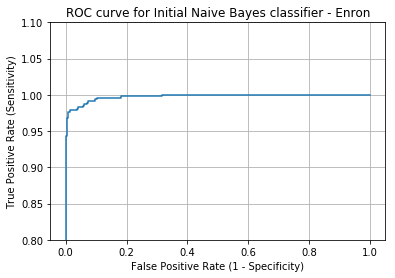

In [19]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = nb.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial Naive Bayes classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
nb_initial_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning NB using grid search 

In [20]:
%%time
## Tuned NB
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.logspace(-2, 2, 100) }
clf = GridSearchCV(MultinomialNB(), param_grid, cv= 5)
clf.fit(email_train_tf, spam_train)
best_alpha = clf.best_estimator_.alpha
print(" Best score: ", clf.best_score_ )
nb_grid_acc = clf.best_score_
print("alpha hyperparameter for best score: ", best_alpha)

 Best score:  0.9932203389830508
alpha hyperparameter for best score:  0.010974987654930561
CPU times: user 8.31 s, sys: 408 ms, total: 8.72 s
Wall time: 8.73 s


In [22]:
TunedNB = MultinomialNB(alpha = 0.010974987654930561)

In [23]:
TunedNB.fit(email_train_tf, spam_train)

MultinomialNB(alpha=0.010974987654930561, class_prior=None, fit_prior=True)

In [24]:
result1a = TunedNB.predict(email_val_tf)

In [26]:
from sklearn import metrics

print("Accuracy on val set:")
print(metrics.accuracy_score(spam_val, result1a))
nb_grid_acc = metrics.accuracy_score(spam_val, result1a)

Accuracy on val set:
0.9887069452286844


In [27]:
from sklearn import metrics

print("Accuracy on val set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on val set:
0.9887069452286844
[[1299    2]
 [  18  452]]


In [28]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9997988454053347


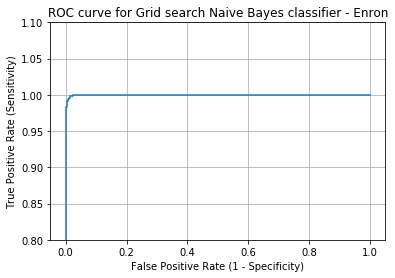

In [29]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = TunedNB.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid search Naive Bayes classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
nb_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning NB using random search 

In [41]:
from sklearn.model_selection import RandomizedSearchCV

In [57]:
%%time
clf = MultinomialNB()
param_dist = {'alpha': np.logspace(-3, 3, 100) }
rand = RandomizedSearchCV(clf, param_dist, cv = 10, scoring = 'accuracy', n_iter = 100, random_state= 5)
rand.fit(email_train_tf, spam_train)
best_a = rand.best_estimator_.alpha
print(" Best score: ", rand.best_score_)
print(rand.best_estimator_.alpha)

 Best score:  0.9950282485875707
0.001747528400007683
CPU times: user 16 s, sys: 542 ms, total: 16.6 s
Wall time: 16.6 s


In [58]:
TunedNB = MultinomialNB(alpha = best_a)

In [59]:
TunedNB.fit(email_train_tf, spam_train)

MultinomialNB(alpha=0.001747528400007683, class_prior=None, fit_prior=True)

In [60]:
result1a = TunedNB.predict(email_val_tf)

In [61]:
from sklearn import metrics

print("Accuracy on validation set:")
print(metrics.accuracy_score(spam_val, result1a))


Accuracy on test set:
0.9892715979672502


### Optunity

### SVM

In [62]:
import sklearn
from sklearn.svm import SVC
clf = SVC(kernel="rbf", probability=True)

# fit tf-idf representation to NB model
clf.fit(email_train_tf, spam_train)


# class predictions for testing set
result1 = clf.predict(email_val_tf)


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [63]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1))
svm_default = metrics.accuracy_score(spam_val, result1)
print (metrics.confusion_matrix(spam_val, result1))

Accuracy on test set:
0.7346132128740824
[[1301    0]
 [ 470    0]]


In [64]:
confusion = metrics.confusion_matrix(spam_val, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9830375979197672


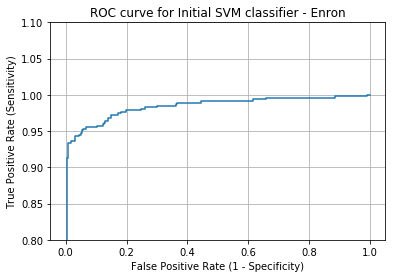

In [65]:
#ROC curve

y_pred_prob = clf.predict_proba(email_val_tf)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial SVM classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
svm_initial_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning SVM using grid search 

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
clf = SVC(kernel="rbf")
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid , cv=5)
grid_search.fit(email_train_tf, spam_train)
grid_search.best_params_


print( grid_search.best_params_)


In [66]:
tunedSVM = SVC(gamma = 0.1, C = 10.0, kernel="rbf", probability=True)

In [67]:
tunedSVM.fit(email_train_tf, spam_train)

SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [68]:
result1a = tunedSVM.predict(email_val_tf)

In [69]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
svm_grid_acc= metrics.accuracy_score(spam_val, result1a)

Accuracy on test set:
0.9932241671372106


In [71]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

[[1298    3]
 [   9  461]]


0.9998609907272639


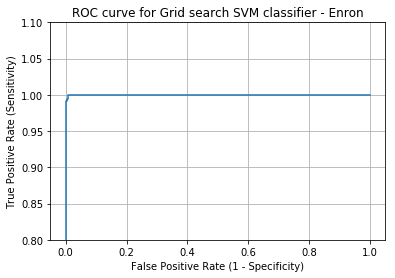

In [74]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedSVM.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid search SVM classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
svm_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning SVM using random search 

In [16]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
clf = SVC(kernel="rbf")
Cs = 10. ** np.arange(-3, 10)
gammas = 10. ** np.arange(-5, 4)
param_dist = {'C': Cs, 'gamma' : gammas}
rand = RandomizedSearchCV(clf, param_dist, cv = 2, scoring = 'accuracy', n_iter = 10, random_state= 5)
rand.fit(email_train_tf, spam_train)
rand.best_params_
print( rand.best_params_)
best_gamma = rand.best_estimator_.gamma
best_C = rand.best_estimator_.C

{'gamma': 0.1, 'C': 10000000.0}
CPU times: user 4min 10s, sys: 1.47 s, total: 4min 12s
Wall time: 4min 14s


In [17]:
tunedSVM = SVC(gamma = best_gamma, C = best_C, kernel="rbf")

In [ ]:
tunedSVM.fit(email_train_tf, spam_train)

In [ ]:
result1a = tunedSVM.predict(email_val_tf)

In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))

In [69]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
svm_grid_acc= metrics.accuracy_score(spam_val, result1a)

Accuracy on test set:
0.9932241671372106


In [71]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

[[1298    3]
 [   9  461]]


0.9998609907272639


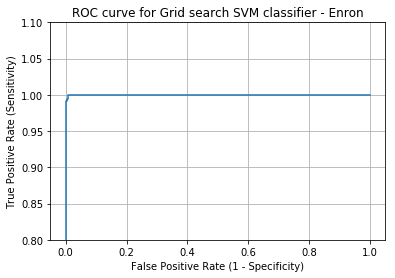

In [74]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedSVM.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid search SVM classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
svm_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Logistic regression

In [25]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
# fit tf-idf representation to NB model
clf.fit(email_train_tf, spam_train)

# class predictions for testing set
result1 = clf.predict(email_val_tf)

CPU times: user 294 ms, sys: 5.14 ms, total: 299 ms
Wall time: 172 ms


In [26]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1))
print (metrics.confusion_matrix(spam_val, result1))
lg_default = metrics.accuracy_score(spam_val, result1)

Accuracy on test set:
0.9836250705815923
[[1297    4]
 [  25  445]]


In [27]:
confusion = metrics.confusion_matrix(spam_val, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

0.995811732382619


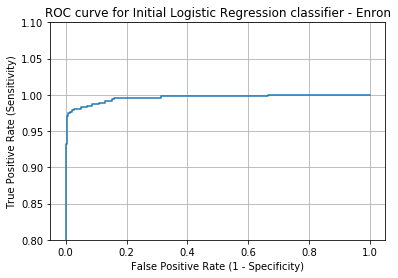

In [31]:
#ROC curve
import matplotlib.pyplot as plt
y_pred_prob = clf.predict_proba(email_val_tf)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial Logistic Regression classifier - Enron')
plt.ylim([0.8, 1.1])
plt.plot( label='ROC curve (area = )')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
lg_initial_auc= metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning Logistic regression using grid search

In [32]:
%%time
clf = LogisticRegression()
param_grid = { 'C' : np.linspace(0.001, 10, 100)}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid , cv=5)
grid_search.fit(email_train_tf, spam_train)
grid_search.best_params_
print(grid_search.best_params_)
best_C = grid_search.best_estimator_.C


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'C': 9.697000000000001}
CPU times: user 1min 48s, sys: 739 ms, total: 1min 49s
Wall time: 55 s


In [33]:
print(best_C)
tunedLG = LogisticRegression(C = best_C)

9.697000000000001


In [34]:
tunedLG.fit(email_train_tf, spam_train)

LogisticRegression(C=9.697000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [35]:
result1a = tunedLG.predict(email_val_tf)

In [36]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))

lg_grid_acc = metrics.accuracy_score(spam_val, result1a)

Accuracy on test set:
0.9915302089215132


In [37]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9915302089215132
[[1298    3]
 [  12  458]]


In [38]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.999695815003189


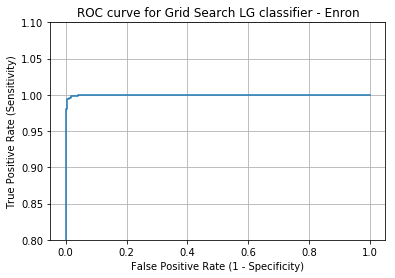

In [39]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedLG.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search LG classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
lg_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning logistic regression using random search 

In [3]:
%%time
from sklearn.model_selection import RandomizedSearchCV

clf = LogisticRegression()

param_grid = { 'C' : np.linspace(0.001, 10, 100)}
RandomizedSearch = RandomizedSearchCV(clf, param_grid, cv = 5 ,scoring = 'accuracy', n_iter = 50, random_state= 5)
RandomizedSearch.fit(email_train_tf, spam_train)
RandomizedSearch.best_params_
print(RandomizedSearch.best_params_)
best_C = RandomizedSearch.best_estimator_.C

NameError: name 'LogisticRegression' is not defined

In [ ]:
print(best_C)
tunedLG = LogisticRegression(C = best_C)

In [ ]:
tunedLG.fit(email_train_tf, spam_train)

In [ ]:
result1a = tunedLG.predict(email_val_tf)

In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))

lg_grid_acc = metrics.accuracy_score(spam_val, result1a)

In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

In [ ]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


In [ ]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedLG.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search LG classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
lg_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
# fit tf-idf representation to NB model
clf.fit(email_train_tf, spam_train)


# class predictions for testing set
result1 = clf.predict(email_val_tf)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1))
rf_default = metrics.accuracy_score(spam_val, result1)

In [ ]:
confusion = metrics.confusion_matrix(spam_test, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

In [ ]:
#ROC curve

y_pred_prob = clf.predict_proba(email_val_tf)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial Random Forest classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
rf_initial_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning Random forest using grid search

In [42]:
clf = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

param_grid = { 'n_estimators' : n_estimators, 'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid , cv=5)
grid_search.fit(email_train_tf, spam_train)
grid_search.best_params_
print(grid_search.best_params_)
best_n = grid_search.best_estimator_.n_estimators
best_max_depth = grid_search.best_estimator_.max_depth
best_min_samples_leaf = grid_search.best_estimator_.min_samples_leaf

KeyboardInterrupt: 

In [43]:
## print(best_n, best_max_depth, best_min_samples_leaf)
tunedRF = RandomForestClassifier(n_estimators = 1000, max_depth = 52,  min_samples_leaf = 1)

In [44]:
tunedRF.fit(email_train_tf, spam_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=52, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [45]:
result1a = tunedRF.predict(email_val_tf)

In [46]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
rf_grid_acc = (metrics.accuracy_score(spam_val, result1a))

Accuracy on test set:
0.9920948616600791


In [47]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9920948616600791
[[1298    3]
 [  11  459]]


In [48]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9997628665347441


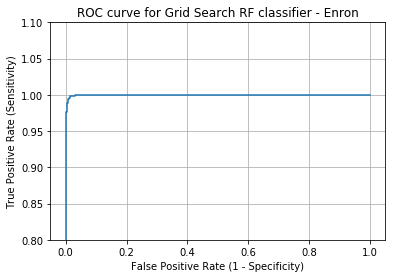

In [49]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedRF.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search RF classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
rf_grid_score = metrics.roc_auc_score(spam_val, y_pred_prob)

## Tuning Random forest using random search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
%%time
clf = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

param_grid = { 'n_estimators' : n_estimators, 'max_depth':max_depth, 'min_samples_leaf':min_samples_leaf}
RandomizedSearch = RandomizedSearchCV(clf, param_grid, cv = 10, scoring = 'accuracy', n_iter = 10, random_state= 5)
RandomizedSearch.fit(email_train_tf, spam_train)
RandomizedSearch.best_params_
print(RandomizedSearch.best_params_)
best_n = RandomizedSearch.best_estimator_.n_estimators
best_max_depth = RandomizedSearch.best_estimator_.max_depth
best_min_samples_leaf = RandomizedSearch.best_estimator_.min_samples_leaf

In [ ]:
## print(best_n, best_max_depth, best_min_samples_leaf)
tunedRF = RandomForestClassifier(n_estimators = best_n, max_depth = best_max_depth,  min_samples_leaf = best_min_samples_leaf)

In [ ]:
tunedRF.fit(email_train_tf, spam_train)

In [ ]:
result1a = tunedRF.predict(email_val_tf)

In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
rf_grid_acc = (metrics.accuracy_score(spam_val, result1a))

In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

In [ ]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


In [ ]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedRF.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search RF classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
rf_grid_score = metrics.roc_auc_score(spam_val, y_pred_prob)

### K neighbours classifier

In [75]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
# fit tf-idf representation to NB model
neigh.fit(email_train_tf, spam_train)


# class predictions for testing set
result1 = neigh.predict(email_val_tf)

In [ ]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1))
knn_default = metrics.accuracy_score(spam_val, result1)

In [ ]:
confusion = metrics.confusion_matrix(spam_val, result1)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(confusion)

In [ ]:
#ROC curve

y_pred_prob = neigh.predict_proba(email_val_tf)[:, 1]


fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Initial K nearest classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
knn_initial_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning K neighbours using grid search

In [76]:
clf = KNeighborsClassifier()
k_range = range(1, 10)
weight_options = ['uniform', 'distance']
param_grid = { 'n_neighbors' :k_range, 'weights' :weight_options}
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid , cv=5)
grid_search.fit(email_train_tf, spam_train)
grid_search.best_params_
print(grid_search.best_params_)
best_k = grid_search.best_estimator_.n_neighbors
best_wt = grid_search.best_estimator_.weights

{'n_neighbors': 4, 'weights': 'distance'}


In [77]:
print(best_k, best_wt)
tunedKNN = KNeighborsClassifier(n_neighbors = best_k, weights= best_wt)

4 distance


In [78]:
tunedKNN.fit(email_train_tf, spam_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [79]:
result1a = tunedKNN.predict(email_val_tf)

In [80]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
knn_grid_acc=(metrics.accuracy_score(spam_val, result1a))

Accuracy on test set:
0.9909655561829475


In [81]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9909655561829475
[[1295    6]
 [  10  460]]


In [82]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9978134659100201


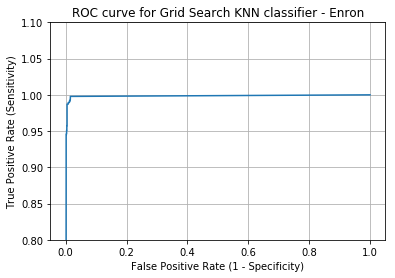

In [83]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedKNN.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search KNN classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
knn_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

### Tuning K neighbours using random search

In [18]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

clf = KNeighborsClassifier()
k_range = range(1, 10)
weight_options = ['uniform', 'distance']
param_grid = { 'n_neighbors' :k_range, 'weights' :weight_options}
RandomizedSearch = RandomizedSearchCV(clf, param_grid, cv = 10, scoring = 'accuracy', n_iter = 10, random_state= 5)
RandomizedSearch.fit(email_train_tf, spam_train)
RandomizedSearch.best_params_
print(RandomizedSearch.best_params_)
best_k = RandomizedSearch.best_estimator_.n_neighbors
best_wt = RandomizedSearch.best_estimator_.weights

{'weights': 'distance', 'n_neighbors': 4}
CPU times: user 3min 29s, sys: 10.1 s, total: 3min 39s
Wall time: 3min 46s


In [19]:
print(best_k, best_wt)
tunedKNN = KNeighborsClassifier(n_neighbors = best_k, weights= best_wt)

4 distance


In [20]:
tunedKNN.fit(email_train_tf, spam_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [21]:
result1a = tunedKNN.predict(email_val_tf)

In [22]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
knn_grid_acc=(metrics.accuracy_score(spam_val, result1a))

Accuracy on test set:
0.9909655561829475


In [23]:
from sklearn import metrics

print("Accuracy on test set:")
print(metrics.accuracy_score(spam_val, result1a))
print (metrics.confusion_matrix(spam_val, result1a))

Accuracy on test set:
0.9909655561829475
[[1295    6]
 [  10  460]]


In [24]:
confusion = metrics.confusion_matrix(spam_val, result1a)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]


0.9978134659100201


ValueError: Classification metrics can't handle a mix of binary and continuous targets

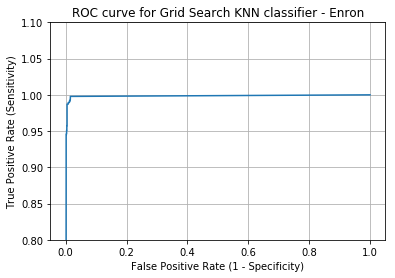

In [28]:
import matplotlib.pyplot as plt
#ROC curve
y_pred_prob = tunedKNN.predict_proba(email_val_tf)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(spam_val, y_pred_prob)
plt.plot(fpr, tpr)

plt.title('ROC curve for Grid Search KNN classifier - Enron')
plt.ylim([0.8, 1.1])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print(metrics.roc_auc_score(spam_val, y_pred_prob))
print(metrics.classification_report(spam_val, y_pred_prob))
knn_grid_auc = metrics.roc_auc_score(spam_val, y_pred_prob)

## Plots 

### Default Accuracy

In [ ]:
model_accs_default = {'NB': nb_default, 'SVM': svm_default, 'LG': lg_default, 'RF': rf_default, 'KNN' : knn_default}
print(model_accs_default)


In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(model_accs_default)), model_accs_default.values(), align='center')

plt.xticks(range(len(model_accs_default)), model_accs_default.keys())

# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
for a,b in zip(range(len(model_accs_default)), model_accs_default.values()):
    plt.text(a-.3, b +.0005,str(round(b, 5)))
    
#plt.tight_layout()
plt.ylim([0.80,1.0])
bl = plt.bar(range(len(model_accs_default)), model_accs_default.values(), align='center');
bl[0].set_color('r')
bl[1].set_color('g')
bl[2].set_color('b')
bl[3].set_color('y')
bl[4].set_color('m')


plt.title('Initial Classifier Model Accuracies - Enron')

### Default AUC

In [ ]:
models_default_auc = {'NB': nb_initial_auc, 'SVM': svm_initial_auc, 'LG': lg_initial_auc, 'RF': rf_initial_auc, 'KNN' : knn_initial_auc}
print(models_default_auc)

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(models_default_auc)), models_default_auc.values(), align='center')

plt.xticks(range(len(models_default_auc)), models_default_auc.keys())

# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
for a,b in zip(range(len(models_default_auc)), models_default_auc.values()):
    plt.text(a-.3, b +.0005,str(round(b, 5)))
    
#plt.tight_layout()
plt.ylim([0.980,1.01])
bl = plt.bar(range(len(models_default_auc)), models_default_auc.values(), align='center');
bl[0].set_color('r')
bl[1].set_color('g')
bl[2].set_color('b')
bl[3].set_color('y')
bl[4].set_color('m')

plt.title('Initial Classifier AUC - Enron')

### Grid search Aaccuracy

In [ ]:
model_accs_grid = {'NB': nb_grid_acc, 'SVM': svm_grid_acc, 'LG': lg_grid_acc, 'RF': rf_grid_acc, 'KNN' : knn_grid_acc}
print(model_accs_grid)

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(model_accs_grid)), model_accs_grid.values(), align='center')

plt.xticks(range(len(model_accs_grid)), model_accs_grid.keys())

# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
for a,b in zip(range(len(model_accs_grid)), model_accs_grid.values()):
    plt.text(a-.3, b +.0005,str(round(b, 5)))
    
#plt.tight_layout()
plt.ylim([0.800,1.0])
bl = plt.bar(range(len(model_accs_grid)), model_accs_grid.values(), align='center');
bl[0].set_color('r')
bl[1].set_color('g')
bl[2].set_color('b')
bl[3].set_color('y')
bl[4].set_color('m')

plt.title('Grid Search Classifier Accuracies - Enron')

### Grid search AUC

In [ ]:
models_grid_auc = {'NB': nb_grid_auc, 'SVM': svm_grid_auc, 'LG': lg_grid_auc, 'RF': rf_grid_score, 'KNN' : knn_grid_auc}
print(models_grid_auc)

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(models_grid_auc)), models_grid_auc.values(), align='center')

plt.xticks(range(len(models_grid_auc)), models_grid_auc.keys())

# https://stackoverflow.com/questions/1221108/barchart-with-vertical-labels-in-python-matplotlib
for a,b in zip(range(len(models_grid_auc)), models_grid_auc.values()):
    plt.text(a-.3, b +.0005,str(round(b, 5)))
    
#plt.tight_layout()
plt.ylim([0.980,1.01])
bl = plt.bar(range(len(models_grid_auc)), models_grid_auc.values(), align='center');
bl[0].set_color('r')
bl[1].set_color('g')
bl[2].set_color('b')
bl[3].set_color('y')
bl[4].set_color('m')

plt.title('Grid Search Classifier AUC - Enron')

In [14]:
model = models.Sequential()
# Input - Layer
model.add(layers.Dense(50, activation = "relu", input_shape=(53285, )))
# Hidden - Layers
model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
model.add(layers.Dense(50, activation = "relu"))
# Output- Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()
# compiling the model
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)
results = model.fit(
 email_train_tf, spam_train,
 epochs= 2,
 batch_size = 500,
 validation_data = (email_val_tf, spam_val)
)
print("Test-Accuracy:", np.mean(results.history["val_acc"]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                2664300   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 2,669,451
Trainable params: 2,669,451
Non-trainable params: 0
_________________________________________________________________
